In [30]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.decomposition import PCA
import sklearn.ensemble
import sklearn.linear_model
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


In [5]:
# create net difference columns
def net_diff_columns(df):
    df['SSN_W'] = df['H_SSN_W'] - df['A_SSN_W']
    df['LAST10_W'] = df['H_LAST10_W'] - df['A_LAST10_W']
    df['LAST5_W'] = df['H_LAST5_W'] - df['A_LAST5_W']
    df['SSN_W_OPP'] = df['H_SEASON_W_OPP'] - df['A_SSN_W_OPP']
    df['LAST10_W_OPP'] = df['H_LAST10_W_OPP'] - df['A_LAST10_W_OPP']
    df['LAST5_W_OPP'] = df['H_LAST5_W_OPP'] - df['A_LAST5_W_OPP']
    df['AVG_PTS'] = df['H_AVG_PTS'] - df['A_AVG_PTS']
    df['AVG_FG_PCT'] = df['H_AVG_FG_PCT'] - df['A_AVG_FG_PCT']
    df['AVG_FGA'] = df['H_AVG_FGA'] - df['A_AVG_FGA']
    df['AVG_FG3M'] = df['H_AVG_FG3M'] - df['A_AVG_FG3M']
    df['AVG_FTM'] = df['H_AVG_FTM'] - df['A_AVG_FTM']
    df['AVG_DREB'] = df['H_AVG_DREB'] - df['A_AVG_DREB']
    df['AVG_OREB'] = df['H_AVG_OREB'] - df['A_AVG_OREB']
    df['AVG_REB'] = df['H_AVG_REB'] - df['A_AVG_REB']
    df['AVG_STL'] = df['H_AVG_STL'] - df['A_AVG_STL']
    df.drop(['H_AVG_PTS', 'A_AVG_PTS', 'H_AVG_FG_PCT', 'A_AVG_FG_PCT', 
             'H_AVG_FGA', 'A_AVG_FGA', 'H_AVG_FG3M', 'A_AVG_FG3M', 'H_AVG_FTM', 
             'A_AVG_FTM', 'H_AVG_DREB', 'A_AVG_DREB', 'H_AVG_OREB', 'A_AVG_OREB', 
             'H_AVG_REB', 'A_AVG_REB', 'H_AVG_STL', 'A_AVG_STL', 'H_SSN_W', 'A_SSN_W',
             'H_LAST10_W', 'A_LAST10_W', 'H_LAST5_W', 'A_LAST5_W', 'H_SEASON_W_OPP',
             'A_SSN_W_OPP', 'H_LAST10_W_OPP', 'A_LAST10_W_OPP', 'H_LAST5_W_OPP',
             'A_LAST5_W_OPP'], axis=1, inplace=True)
    return df

### Fetch data and simple preproccessing

In [23]:
# fetch yearly data and remove first 100 games
gbg_22_23 = pd.read_csv('data/gbg_22-23.csv')
gbg_22_23 = gbg_22_23.iloc[:-100]
gbg_21_22 = pd.read_csv('data/gbg_21-22.csv')
gbg_21_22 = gbg_21_22.iloc[:-100]
gbg_20_21 = pd.read_csv('data/gbg_20-21.csv')
gbg_20_21 = gbg_20_21.iloc[:-100]
# gbg_19_20 = pd.read_csv('data/gbg_19-20.csv')
# gbg_19_20 = gbg_19_20.iloc[:-100]
gbg_18_19 = pd.read_csv('data/gbg_18-19.csv')
gbg_18_19 = gbg_18_19.iloc[:-100]

# combine data and remove unnecessary columns
gbg_data = pd.concat([gbg_21_22, gbg_22_23, gbg_20_21, gbg_18_19])
gbg_data = gbg_data.drop('Unnamed: 0', axis=1)
gbg_data.reset_index(drop=True)
gbg_data = gbg_data.drop(['H_TEAM', 'A_TEAM'], axis=1)

# encoding wins as 1/0
gbg_data["H_TEAM_WIN"] = gbg_data["H_TEAM_WIN"].replace({"W": 1, "L": 0})

# create net difference columns
gbg_data = net_diff_columns(gbg_data)

team_data_majority = gbg_data[gbg_data['H_TEAM_WIN']==1]
team_data_minority = gbg_data[gbg_data['H_TEAM_WIN']==0]

# upscaling minority (adding more home team loss)
# team_data_minority_upsampled = resample(team_data_minority, replace=True, n_samples=team_data_majority.shape[0], random_state=123)
# gbg_data = pd.concat([team_data_majority, team_data_minority_upsampled])

# downscaling majority (removing some home team win)
# team_data_majority_downsampled = resample(team_data_majority, replace=False, n_samples=team_data_minority.shape[0], random_state=123)
# gbg_data = pd.concat([team_data_majority_downsampled, team_data_minority])

# shuffling combined data
gbg_data = gbg_data.sample(frac=1).reset_index(drop=True)
# define features and target
game_result = gbg_data["H_TEAM_WIN"]
game_data = gbg_data.drop("H_TEAM_WIN", axis=1)
# Keep only rows where 'H_TEAM_WIN' contains integers
gbg_data = gbg_data[gbg_data['H_TEAM_WIN'].apply(lambda x: isinstance(x, int))]

In [7]:
# using Recursive Feature Elimination (RFE) to get best features
# Apply RFE
estimator = sklearn.ensemble.RandomForestRegressor()
# estimator = sklearn.linear_model.LinearRegression()
# estimator = neighbors.KNeighborsRegressor()
# estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=12, step=1)
selector = selector.fit(game_data, game_result)
rfe_selected_features = game_data.columns[selector.support_]
print(rfe_selected_features)
game_data = game_data[rfe_selected_features]

Index(['SSN_W', 'LAST10_W', 'LAST5_W', 'AVG_PTS', 'AVG_FG_PCT', 'AVG_FGA',
       'AVG_FG3M', 'AVG_FTM', 'AVG_DREB', 'AVG_OREB', 'AVG_REB', 'AVG_STL'],
      dtype='object')


In [24]:
# normalizing data
scaler = skp.StandardScaler()
game_data_scaled = scaler.fit_transform(game_data)

# apply PCA
pca = PCA(n_components=5)
game_data_scaled = pca.fit_transform(game_data_scaled)

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(game_data_scaled, game_result, test_size=0.2, random_state=78)

gbg_data

,H_TEAM_WIN,SSN_W,LAST10_W,LAST5_W,SSN_W_OPP,LAST10_W_OPP,LAST5_W_OPP,AVG_PTS,AVG_FG_PCT,AVG_FGA,AVG_FG3M,AVG_FTM,AVG_DREB,AVG_OREB,AVG_REB,AVG_STL
0,1,5,1,2,0,0,0,3.944444,0.031056,-2.555556,-1.722222,1.055556,-1.777778,-0.277778,-2.055556,-0.722222
1,0,-2,-2,-2,0,0,0,-8.350000,0.007650,-6.000000,-3.700000,-0.250000,-2.750000,-6.250000,-9.000000,0.250000
2,1,10,3,2,0,0,0,2.800000,-0.017000,6.650000,-1.900000,1.100000,-2.500000,5.700000,3.200000,2.050000
3,1,-4,3,2,0,0,0,6.850000,0.003850,6.050000,-2.800000,3.650000,0.050000,3.700000,3.750000,1.000000
4,1,3,0,1,0,0,0,0.850000,-0.022450,5.050000,3.050000,-3.200000,5.500000,1.400000,6.900000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293,1,-4,0,-1,0,0,0,3.400000,0.032650,-3.050000,-1.000000,1.400000,1.050000,-3.250000,-2.200000,-2.850000
7294,1,-9,0,0,0,0,0,4.200000,0.003850,-0.550000,0.150000,3.750000,5.000000,-0.250000,4.750000,-3.450000
7295,1,1,2,0,-1,-1,-1,2.550000,0.006350,-3.100000,2.500000,1.350000,4.000000,-1.350000,2.650000,-2.500000
7296,1,-1,-2,0,0,0,0,-4.898990,-0.001263,0.797980,-1.050505,-4.676768,-3.060606,0.434343,-2.626263,-1.060606


### simple models

In [25]:
# knn_model = neighbors.KNeighborsClassifier(n_neighbors=6)
# knn_model.fit(X_train, y_train)
# y_pred = knn_model.predict(X_test)

# logistic_model
logistic_model = sklearn.linear_model.LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

# random forest model
# rf_model = sklearn.ensemble.RandomForestClassifier()
# rf_model.fit(X_train, y_train)
# y_pred = rf_model.predict(X_test)


In [26]:
# applying GridsearchCV to the model
# knn search
# param_grid = {
#     'n_neighbors': [15, 20, 25, 30, 35, 40, 45, 50],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan', 'minkowski'],
#     }

# logisitic search
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
    }

# random forest search
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
#     }

# grid search
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solv

accuracy is 0.6061643835616438
mae is 0.3938356164383562
recall is 0.6061643835616438
precision is 0.5983624382546717
r2 is -0.6048587361092264
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.41      0.47       631
           1       0.63      0.76      0.69       829

    accuracy                           0.61      1460
   macro avg       0.59      0.58      0.58      1460
weighted avg       0.60      0.61      0.59      1460



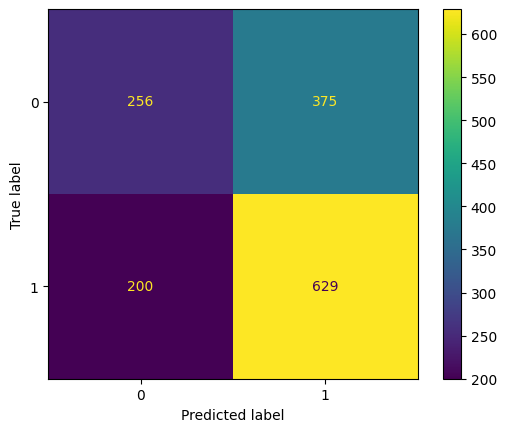

In [27]:
print('accuracy is ' + str(metrics.accuracy_score(y_test, y_pred)))
print('mae is ' + str(metrics.mean_absolute_error(y_test, y_pred)))
print('recall is ' + str(metrics.recall_score(y_test, y_pred, average='weighted')))
print('precision is ' + str(metrics.precision_score(y_test, y_pred, average='weighted')))
print('r2 is ' + str(metrics.r2_score(y_test, y_pred)))


report = metrics.classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(report)

#confusion matrix
confusionmatrix = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusionmatrix)
disp.plot()
plt.show()

### Neural Network model

In [33]:
# defining the model
model = Sequential([
    Dense(64, input_shape=(5,), activation='relu'),  # Input layer with 12 features
    Dense(64, activation='relu', kernel_regularizer=l2(0.02)),   # Hidden layer
    Dense(32, activation='relu'),   # Hidden layer
    # Dense(12, activation='relu', kernel_regularizer=l2(0.01)),   # Hidden layer
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.add(BatchNormalization())
model.add(Dropout(0.01))

model.compile(optimizer=optimizer, # optimizer for gradient descent
              loss='binary_crossentropy', # loss function for binary classification
              metrics=['binary_accuracy'])

history = model.fit(X_train, y_train, epochs=150, batch_size=40, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test accuracy: {}'.format(test_accuracy))

Epoch 1/150
117/117 [==============================] - 0s 2ms/step - loss: 4.5462 - binary_accuracy: 0.5330 - val_loss: 2.4416 - val_binary_accuracy: 0.4366
Epoch 2/150
117/117 [==============================] - 0s 964us/step - loss: 3.6925 - binary_accuracy: 0.5343 - val_loss: 3.0725 - val_binary_accuracy: 0.4409
Epoch 3/150
117/117 [==============================] - 0s 939us/step - loss: 3.2529 - binary_accuracy: 0.5630 - val_loss: 3.0732 - val_binary_accuracy: 0.4675
Epoch 4/150
117/117 [==============================] - 0s 944us/step - loss: 3.0866 - binary_accuracy: 0.5634 - val_loss: 2.9736 - val_binary_accuracy: 0.5565
Epoch 5/150
117/117 [==============================] - 0s 918us/step - loss: 2.9561 - binary_accuracy: 0.5666 - val_loss: 2.9218 - val_binary_accuracy: 0.5813
Epoch 6/150
117/117 [==============================] - 0s 933us/step - loss: 2.8077 - binary_accuracy: 0.5786 - val_loss: 2.5567 - val_binary_accuracy: 0.5788
Epoch 7/150
117/117 [===========================

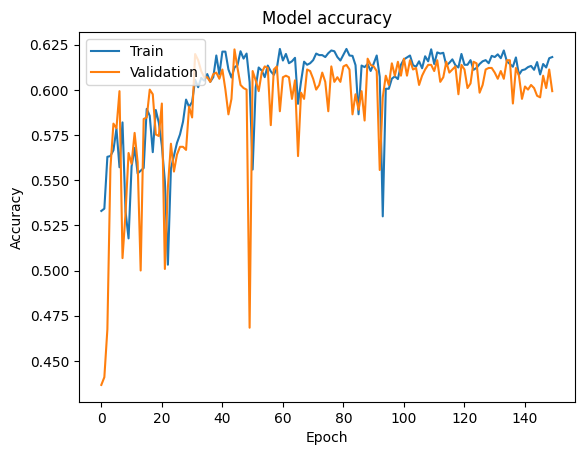

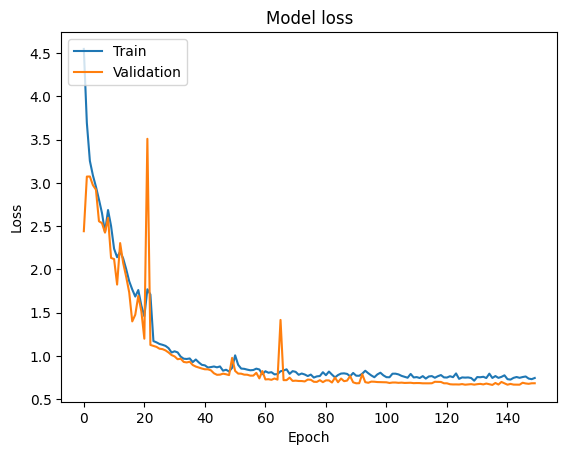

In [34]:
# history = model.fit(X_train, y_train, epochs=70, validation_split=0.2)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

34/34 [==============================] - 0s 418us/step
accuracy is 0.6086547507055503
mae is 0.3913452492944497
recall is 0.6086547507055503
precision is 0.602743393448412
r2 is -0.5918214542836575
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.36      0.44       463
           1       0.62      0.80      0.70       600

    accuracy                           0.61      1063
   macro avg       0.60      0.58      0.57      1063
weighted avg       0.60      0.61      0.59      1063



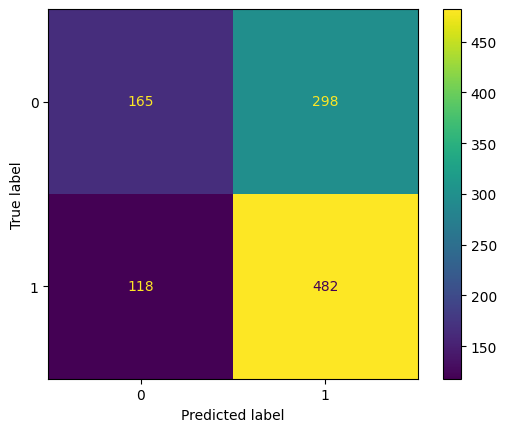

In [291]:
y_pred = model.predict(X_test)
# Set a threshold (e.g., 0.5) to convert probabilities to binary class labels
threshold = 0.5
y_pred = (y_pred >= threshold).astype(int)

print('accuracy is ' + str(metrics.accuracy_score(y_test, y_pred)))
print('mae is ' + str(metrics.mean_absolute_error(y_test, y_pred)))
print('recall is ' + str(metrics.recall_score(y_test, y_pred, average='weighted')))
print('precision is ' + str(metrics.precision_score(y_test, y_pred, average='weighted')))
print('r2 is ' + str(metrics.r2_score(y_test, y_pred)))


report = metrics.classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(report)

#confusion matrix
confusionmatrix = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusionmatrix)
disp.plot()
plt.show()